# Tutorial for "Advances in machine learning for molecules" -- Solutions
_Summer school for Machine Learning in Bioinformatics, Moscow_  
John Bradshaw, August 2020

This notebook has been designed to complement Miguel's lecture earlier this afternoon by demonstrating some of the concepts he discussed. We will begin by importing the associated dependencies to run this notebook, see the repo's README for details on how to get these installed. After this, we will then describe how one can manipulate molecules in [RDKIT](https://rdkit.org/), a popular chemoinformatics toolkit, of which no existing knowledge of is expected. We will then go on to implementing and testing the regression models on molecules Miguel described, namely MLP on fingerints, RNN/CNN on SMILES strings, and GNNs on the molecular graph. 

Tasks which you need to complete I have labelled with **🧪 Task #** , and the missing code location with `# ====== TASK -- FILL IN ======` in the code cell. Completing these will require some basic knowledge of [PyTorch](https://pytorch.org/), if you haven't used this before you can go through the tutorial [here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or read through the [docs](https://pytorch.org/docs/stable/index.html) as and when this is needed (I've tried to add links to relevant parts where appropriate). I wasn't sure on everyone's background so I apologize if this notebook is either too long or too short. To this end there are some optional tasks (marked with 🕰 ) which you can do later or simply ignore! I have also tried to include links at the end of each section for further reading. Finally, if you spot any bugs/typos (sorry  😳 ), please create a GitHub issue or PR and I can fix them!


## 1. Imports

This section will start by installing any missing packages if you're running in Colab. Then it will import all the required modules needed later. See the repo's README for further details about installation.

### Install missing packages on Google Colab

If you're running on Colab the cell below should install the missing requirements.


In [1]:

# Some standard library imports that we need to run the rest of this cell:
import os
import sys
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


# We are first going to check if we are in Colab.
IN_COLAB = 'google.colab' in sys.modules

# If in Colab then we will install some more packages
if IN_COLAB:
    print("Detected that you're running the notebook in Colab --"
          "will install mising packages (this can take a few ming)")
    !python --version
    
    # Some missing things which can be obtained through pip
    !pip install pytorch-ignite 
    !pip install watermark
    
    # We need to clone our repo and go inside so that can load our  module/dataset
    ! git clone https://github.com/john-bradshaw/ml-in-bioinformatics-summer-school-2020
    os.chdir('ml-in-bioinformatics-summer-school-2020')

    # We are now going to install RDKit (chemoinformatics toolkit) 
    # I've copied the code to do this from: https://gist.github.com/philopon/a75a33919d9ae41dbed5bc6a39f5ede2
    # Which attempts to install it via miniconda with the same Python version as Colab is using and then adding
    # the miniconda site-packages directory to the path.
    logger = getLogger(__name__)
    logger.addHandler(StreamHandler())
    logger.setLevel(INFO)
    
    
    def install(
            chunk_size=4096,
            file_name="Miniconda3-latest-Linux-x86_64.sh",
            url_base="https://repo.continuum.io/miniconda/",
            conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
            rdkit_version=None,
            add_python_path=True,
            force=False):
        """install rdkit from miniconda
        ```
        import rdkit_installer
        rdkit_installer.install()
        ```
        """

        python_path = os.path.join(
            conda_path,
            "lib",
            "python{0}.{1}".format(*sys.version_info),
            "site-packages",
        )

        if add_python_path and python_path not in sys.path:
            logger.info("add {} to PYTHONPATH".format(python_path))
            sys.path.append(python_path)

        if os.path.isdir(os.path.join(python_path, "rdkit")):
            logger.info("rdkit is already installed")
            if not force:
                return

            logger.info("force re-install")

        url = url_base + file_name
        python_version = "{0}.{1}.{2}".format(*sys.version_info)

        logger.info("python version: {}".format(python_version))

        if os.path.isdir(conda_path):
            logger.warning("remove current miniconda")
            shutil.rmtree(conda_path)
        elif os.path.isfile(conda_path):
            logger.warning("remove {}".format(conda_path))
            os.remove(conda_path)

        logger.info('fetching installer from {}'.format(url))
        res = requests.get(url, stream=True)
        res.raise_for_status()
        with open(file_name, 'wb') as f:
            for chunk in res.iter_content(chunk_size):
                f.write(chunk)
        logger.info('done')

        logger.info('installing miniconda to {}'.format(conda_path))
        subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
        logger.info('done')

        logger.info("installing rdkit")
        subprocess.check_call([
            os.path.join(conda_path, "bin", "conda"),
            "install",
            "--yes",
            "-c", "rdkit",
            "python=={}".format(python_version),
            "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
        logger.info("done")

        import rdkit
        logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


    install()

    print("Installed Colab specifics -- now try running the cells below.")
else:
    print("Not in Colab, ensure that you have setup the required packages in an alternative way (e.g. via Conda).")



Not in Colab, ensure that you have setup the required packages in an alternative way (e.g. via Conda).


### Imports

We can now check that the installation worked correctly by making sure we can import the required Python modules by running the code cells below.

In [2]:
# = import items from the Python standard library

import functools
import typing
import importlib
import itertools
import copy

In [3]:
# = import numpy, matplotlib and other useful common libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  # for debugging
import tabulate
import altair as alt
from IPython.core.display import display, HTML
#alt.renderers.enable('notebook')


In [4]:
# = import the parts of RDKit that we need
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools


In [5]:
# = import the parts of PyRorch that we need

import torch
from torch.utils import data 
from torch import nn
from torch.nn import functional as F


In [6]:
# = import the local Python modules we have written
import ss_utils

In [7]:
# = print out our environment  -- doesn't matter if this cell does not work
%load_ext watermark
%watermark -v  -p numpy,scipy,torch -g
print(f"RDKit: {rdkit.__version__}")

CPython 3.7.7
IPython 7.17.0

numpy 1.19.1
scipy 1.5.2
torch 1.6.0
Git hash: 7033e97884b1009a6adf26902ac6aaf0a9ee03e8
RDKit: 2020.03.1


If that all worked, great! We can move onto the next section where we describe how to get started with RDKit.

## 2. Manipulating Molecules using RDKit

This section will describe different ways to represent molecules. We reintroduce the SMILES string format (you should have already seen this in Miguel's lecture) and describe how one can read in these strings using RDKit and plot the resulting molecules.
We then go on to show how you can convert SMILES to alternative molecular representations, such as molecular graphs and fingerprints. 

### 2.1 Reading in SMILES strings

SMILES (Simplified molecular-input line-entry system) proposed by Weininger (1988) is a popular method to represent molecules as ASCII strings. The string is created by printing out the nodes found on a traversal of the molecular graph. For our purposes it is not particularly important how this traversal happens but note how atoms are represented by their usual element symbol (i.e. carbon by 'C', oxygen by 'O', etc), bonds by the symbols `. - = # $ : / \`, branching by parentheses, and rings by numbers. 

If this is confusing don't worry, this will probably be made clearer by a few examples! Let's start by defining a string variable containing the SMILES representation of the paracetemol (i.e. acetaminophen) molecule, a popular painkiller (although I very much hope this notebook does _not_ require it!), and reading it into RDKit.

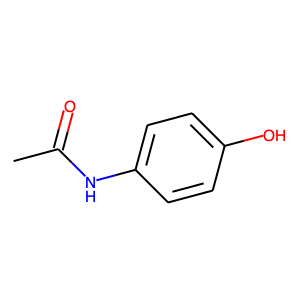

In [8]:
paracetemol_str = 'CC(=O)Nc1ccc(O)cc1'

paracetemol_mol = Chem.MolFromSmiles(paracetemol_str)

Draw.MolToImage(paracetemol_mol)

Note that there is a one-to-many mapping between molecules and their SMILES string representations depending on how one traverses the molecular graph. For instance below we print out 5 different SMILES representations for paracetemol:

In [9]:
rng = np.random.RandomState(10)

# We will then print 5 
paracetemol_random_smiles = [ss_utils.random_ordered_smiles(paracetemol_str, rng) for _ in range(5)]
print(f"Paracetemol can be represented by any of these SMILES (and others): {', '.join(paracetemol_random_smiles)}.")

Paracetemol can be represented by any of these SMILES (and others): O=C(Nc1ccc(O)cc1)C, c1(O)ccc(NC(=O)C)cc1, c1(O)ccc(NC(=O)C)cc1, O=C(C)Nc1ccc(O)cc1, c1c(NC(C)=O)ccc(O)c1.


However, sometimes we want to ensure that we print out a unique SMILES for each molecule, which is useful for instance when comparing two SMILES strings. For this we can use RDKit to compute the _canonical_ SMILES. So in the next cell we read in each of these randomly chosen SMILES for paracetemol back in and convert them to canonical form: 

In [10]:
set([Chem.MolToSmiles(Chem.MolFromSmiles(smi), canonical=True) for smi in paracetemol_random_smiles])
# ^ set should only have one string in it -- incidently the same as we started with as I began with the canonical representation.


{'CC(=O)Nc1ccc(O)cc1'}

See we have ended up with only one representation, the canonical representation!

Once we have converted the SMILES to a RDKit `Mol` object (which happened when running `Chem.MolFromSmiles`) we can manipulate it in different ways. For example, we can iterate through the atoms or bonds:

In [11]:
# Iterate through the atoms. Print their symbol,  atomic number, and number of Hydrogens
for atm in paracetemol_mol.GetAtoms():
    print(f"Atom element: {atm.GetSymbol()}, atomic number: {atm.GetAtomicNum()}, number of hydrogens {atm.GetTotalNumHs()}")

    
print("\n\n")


# Iterate through the bonds..
for bnd in paracetemol_mol.GetBonds():
    print(f"Bond from {bnd.GetBeginAtomIdx()} to {bnd.GetEndAtomIdx()} and is of type {bnd.GetBondType()}.")


Atom element: C, atomic number: 6, number of hydrogens 3
Atom element: C, atomic number: 6, number of hydrogens 0
Atom element: O, atomic number: 8, number of hydrogens 0
Atom element: N, atomic number: 7, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 0
Atom element: C, atomic number: 6, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 0
Atom element: O, atomic number: 8, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 1



Bond from 0 to 1 and is of type SINGLE.
Bond from 1 to 2 and is of type DOUBLE.
Bond from 1 to 3 and is of type SINGLE.
Bond from 3 to 4 and is of type SINGLE.
Bond from 4 to 5 and is of type AROMATIC.
Bond from 5 to 6 and is of type AROMATIC.
Bond from 6 to 7 and is of type AROMATIC.
Bond from 7 to 8 and is of type SINGLE.
Bond from 7 to 9 and is of type AROMATIC.
Bo

Can you match up the two oxygens printed out to the two oxygens in the molecular graph plotted earlier?
If you want you can experiment with obtaining more details about the particular atoms or bonds, the APIs are [here](https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html) and [here](https://www.rdkit.org/docs/cppapi/classRDKit_1_1Bond.html).

Note that when we iterated through the atoms we also printed the number of hydrogen atoms attached. You may have spotted that these hydrogen atoms were not included in the original SMILES string. In general we ignore the hydrogen atoms (they are treated implicitly) but we can include them in SMILES strings if we wanted:

In [12]:
print(Chem.MolToSmiles(paracetemol_mol, allHsExplicit=True))

[CH3][C](=[O])[NH][c]1[cH][cH][c]([OH])[cH][cH]1


We can also print out to other string representations. For instance below we will print out the InChI and InChIKey representations (Heller, 2013):

In [13]:
print(Chem.MolToInchi(paracetemol_mol))
print(Chem.MolToInchiKey(paracetemol_mol))

InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2-5,11H,1H3,(H,9,10)
RZVAJINKPMORJF-UHFFFAOYSA-N


### 2.2 Moving beyond character string representations

Of course, as you saw in the lecture earlier, character strings are not the only way to represent molecules. An alternative approach is to represent molecules as molecular fingerprints. For instance if we want to compute the Morgan fingerprints of the paracetemol molecule we can do so as follows:

In [14]:

# We'll define a function to take in the SMILES string and return the Morgan fingerprint as a numpy array.
# this function will be wrapped inside a least recently used (LRU) cache -- you can ignore this, 
# it just saves a bit of compute later

@functools.lru_cache(int(1e6))
def morgan_fp_from_smiles(smiles_str, radius=2, number_bits=1024):
    mol = AllChem.MolFromSmiles(smiles_str)
    # although it is a bit vector we will represent it as float array in numpy so that can be input more easily into NN later
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=number_bits), dtype=np.float32)


# Having set up this function we can now use it on the paracetemol SMILES string:
print(f"Morgan fingerprint for paracetemol is {morgan_fp_from_smiles(paracetemol_str)}")

# Most of the elements are zero but a few bits will also be set:
print(f"The non-zero indices of the Morgan fingerprint for paracetemol"
      f" are {np.nonzero(morgan_fp_from_smiles(paracetemol_str))}")


Morgan fingerprint for paracetemol is [0. 0. 0. ... 0. 0. 0.]
The non-zero indices of the Morgan fingerprint for paracetemol are (array([  33,   53,  128,  191,  245,  289,  356,  530,  578,  650,  726,
        745,  754,  792,  807,  843,  849,  893, 1017]),)


Note unlike the mapping from SMILES to molecule, there is not necessarily a one-to-one mapping from fingerprint to molecule. 

These fingerprints can be used as feature vectors for ML models (as we shall see later). Fingerprints can also be used to compare molecules and obtain a relatively cheap-to-compute notion of similarity between different molecules. A common way to do this is through the Tanimoto similarity between two fingerprints:

\begin{array}
\textrm{Tanimoto}(\textrm{fp}^1, \textrm{fp}^1) = \frac{\sum_i \textrm{fp}^1_i \wedge \textrm{fp}^2_i}{\sum_i \textrm{fp}^1_i \vee \textrm{fp}^2_i},
\end{array}

where $\wedge$ and $\vee$ are the "bitwise and" and "bitwise or" expressions respectively. 

🧪   **Task 1:** Code up a function to take in two SMILES strings and compute their Tanimoto similarity. Use this function to look at the similarity between paracetemol and the molecules defined in the list below (feel free to also plot their structures).

Glucose


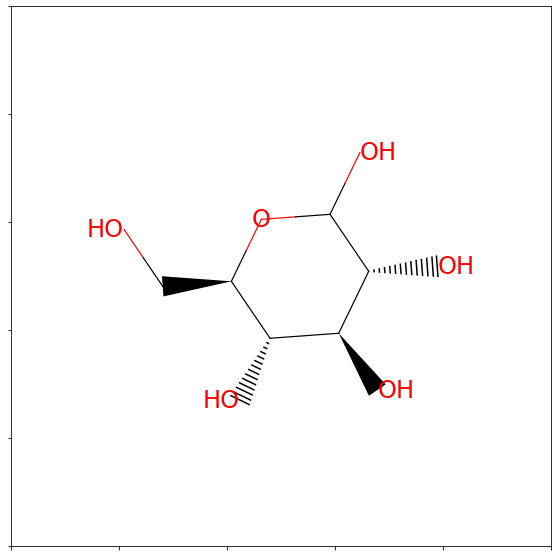

0.02857142857142857






Thiamine (Vitamin B1)


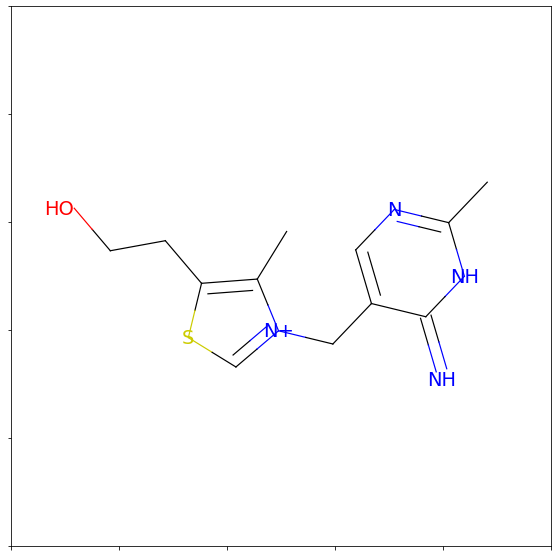

0.07142857142857142






Ibuprofen


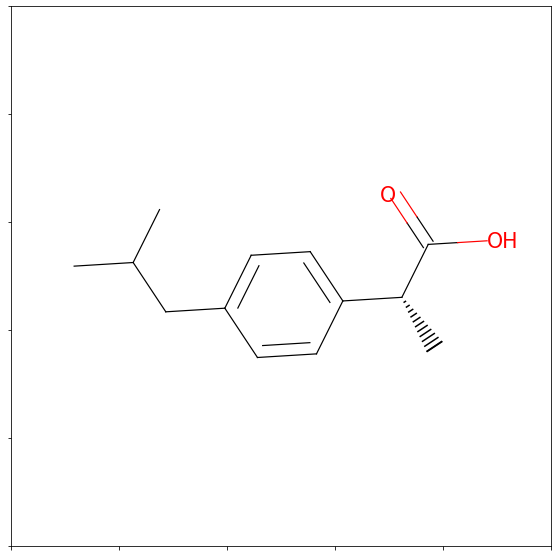

0.1891891891891892








In [15]:
def tanimoto_similarity(smiles_str_1, smiles_str_2):
    fp1 = morgan_fp_from_smiles(smiles_str_1)
    fp2 = morgan_fp_from_smiles(smiles_str_2)
    # nb although the fingerprints are binary we are treating them as floats in numpy
    return np.sum(fp1*fp2) / np.sum((fp1+fp2) > 0) 

molecules_to_compare = {
    'Glucose': 'OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O',  
    'Thiamine (Vitamin B1)': 'Cc1c(sc[n+]1Cc2cnc([nH]c2=N)C)CCO',   
    'Ibuprofen': 'CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O'   
}

for name, other_smi in molecules_to_compare.items():
    print(name)
    Draw.MolToMPL(Chem.MolFromSmiles(other_smi))
    plt.show()
    print(tanimoto_similarity(paracetemol_str, other_smi))
    print("\n"*5)


Which is most similar using this metric? Does this match your intuitions?

🕰  **(optional) Task A -- Similarity Maps:** Look at producing a similarity map to visualize the similarity between paracetemol and the other molecules considered. RDKit has built-in functionality to produce these plots, which is documented [here](http://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity).


Fingerprints are useful as a vector representation that can be used directly with many common ML algorithms. However, it is also useful to have access to a graph representation of the molecule, for use with ML models that work directly on graphs, such as SVMs with graph kernels (Shervashidze, 2011) or graph neural networks (GNNs) (Duvenaud, 2015; Gilmer, 2017). For graph neural networks we need a suitable way to represent graphs as tensors/arrays so that they can be manipulated using deep learning libraries/frameworks. One possible useful array representation is the node feature list and adjacency matrix of a molecule:

In [16]:
# Compute the node feature list
class SymbolFeaturizer:
    """
    Symbol featurizer takes in a symbol and returns an array representing its
    one-hot encoding.
    """
    def __init__(self, symbols, feature_size=None):
        self.atm2indx = {k:i for i, k in enumerate(symbols)}
        self.indx2atm = {v:k for k,v in self.atm2indx.items()}
        self.feature_size = feature_size if feature_size is not None else len(symbols)
    
    def __call__(self, atom_symbol):
        out = np.zeros(self.feature_size)
        out[self.atm2indx[atom_symbol]] = 1.
        return out

    
atm_featurizer = SymbolFeaturizer(['C', 'N', 'O'])
node_features = [atm_featurizer(atm.GetSymbol()) for atm in paracetemol_mol.GetAtoms()]
node_features = np.array(node_features)
print(f"Node features:\n {node_features}")


# Compute the adjacency matrix for paracetemol from rdkit 
num_nodes = paracetemol_mol.GetNumAtoms()
adj_mat = np.zeros((num_nodes, num_nodes))

for bnd in paracetemol_mol.GetBonds():
    adj_mat[bnd.GetBeginAtomIdx(), bnd.GetEndAtomIdx()] = bnd.GetBondTypeAsDouble()  
    adj_mat[bnd.GetEndAtomIdx(), bnd.GetBeginAtomIdx()] = bnd.GetBondTypeAsDouble()

print(f"\n\nAdjacency matrix:\n {adj_mat}")

Node features:
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


Adjacency matrix:
 [[0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.  2.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  1.5 0.  0.  0.  0.  1.5]
 [0.  0.  0.  0.  1.5 0.  1.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.5 0.  1.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.5 0.  1.  1.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.5 0.  0.  1.5]
 [0.  0.  0.  0.  1.5 0.  0.  0.  0.  1.5 0. ]]


Note that many of the elements of the adjacency matrix are zero -- our graph is sparse. The adjacency matrix is a useful representation in many ways, for instance we can quickly compute the degree of a node by looking along the relebant row. However, when we want to batch up multiple graphs together, using the adjacency matrix representation will require us to add padding to account for different sized graphs. An alternative is to store the edge information as a list of edges as well as a list of edge features. So for example with paracetemol we could represent it as:

\begin{array}
\textrm{edge\_list} = \begin{bmatrix}
[0, 1] \\
[1, 0] \\
[1, 2]  \\
[2, 1]  \\
[1, 3]  \\
[3, 1]  \\
[3, 4]  \\
[4, 3]  \\
[4, 5]  \\
[5, 4]  \\
[5, 6]  \\
[6, 5]  \\
[6, 7]  \\
[7, 6]  \\
[7, 8]  \\
[8, 7]  \\
[7, 9]  \\
[9, 7]  \\
[9, 10]  \\
[10, 9]  \\
[10, 4]  \\
[4, 10]  \\
\end{bmatrix}
\end{array}

\begin{array}
\textrm{edge\_features} = \begin{bmatrix}
1 \\
1 \\
2  \\
2  \\
1  \\
1  \\
1  \\
1  \\
1.5  \\
1.5  \\
1.5  \\
1.5  \\
1.5  \\
1.5  \\
1  \\
1  \\
1.5 \\
1.5  \\
1.5  \\
1.5 \\
1.5  \\
1.5  \\
\end{bmatrix}
\end{array}


When we have assigned the following indices to the atoms:


<img src="https://raw.githubusercontent.com/john-bradshaw/ml-in-bioinformatics-summer-school-2020/master/imgs/paracetemol_atom_mapped.svg" width="250px" />

Although, as you'll see later, it does not actually matter in which order we assign indices to the atoms, or the order in which we decide to include the edges -- the GNNs will be invariant to this ordering. Also note that, as the edges are undirected, we include them going both ways.


🧪   **Task 2:** Code up a function to take in a RDKit `Mol` object and return three numpy arrays: the node features array (use the same atom featurizer we defined above), the edge list array and the edge features array. You can index the atoms however you like as long as you are consistent across the three different arrays.


In [17]:
def mol_to_edge_list_graph(mol: Chem.Mol, atm_featurizer: SymbolFeaturizer) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Function that takes in a RDKit molecule (of N atoms, E bonds) and returns three numpy arrays:
    * the node features array (of dtype np.float32, shape [N, d]), which is a one hot encoding 
    of the element of each atom type.
    * the edge list (of dtype np.int32, shape [2E, 2]) that represents the start and end index
    of each edge.
    * the edge feature list (of dtype np.float32, shape [2E, 1]) which describes the feature type
    associated with each edge.
    """
    # Node features
    node_features = [atm_featurizer(atm.GetSymbol()) for atm in mol.GetAtoms()]
    node_features = np.array(node_features, dtype=np.float32)
    
    # Edge list and edge feature list
    edge_list = []
    edge_feature_list = []
    for bnd in mol.GetBonds():
        bnd_indices = [bnd.GetBeginAtomIdx(), bnd.GetEndAtomIdx()]
        bnd_type = bnd.GetBondTypeAsDouble()
        edge_list.extend([bnd_indices,  bnd_indices[::-1]])
        edge_feature_list.extend([bnd_type, bnd_type])
    edge_list = np.array(edge_list, dtype=np.int32)
    edge_feature_list = np.array(edge_feature_list, dtype=np.float32)
    
    return node_features, edge_list, edge_feature_list
    

node_features, edge_list, edge_feature_list = mol_to_edge_list_graph(paracetemol_mol, atm_featurizer)
print(f"Node feature list:\n{node_features}")
print(f"\nEdge list:\n{edge_list}")
print(f"\nEdge feature list:\n{edge_feature_list}")

Node feature list:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]

Edge list:
[[ 0  1]
 [ 1  0]
 [ 1  2]
 [ 2  1]
 [ 1  3]
 [ 3  1]
 [ 3  4]
 [ 4  3]
 [ 4  5]
 [ 5  4]
 [ 5  6]
 [ 6  5]
 [ 6  7]
 [ 7  6]
 [ 7  8]
 [ 8  7]
 [ 7  9]
 [ 9  7]
 [ 9 10]
 [10  9]
 [10  4]
 [ 4 10]]

Edge feature list:
[1.  1.  2.  2.  1.  1.  1.  1.  1.5 1.5 1.5 1.5 1.5 1.5 1.  1.  1.5 1.5
 1.5 1.5 1.5 1.5]


To check that the code you wrote is working correctly I have written a function that goes the other way (i.e. from these arrays back to a SMILES string). Note that the function you wrote is not reversible for all molecules (e.g. in the graph arrays representation we ignore stereochemistry) but should work okay and act as a useful sanity check with paracetemol. To check your code run the cell below and check that the output is `True`:

In [18]:
sanity_check_passed = (Chem.MolToSmiles(paracetemol_mol, canonical=True) == 
                       ss_utils.graph_as_edge_list_to_canon_smiles(node_features, edge_list,
                                                                   edge_feature_list, atm_featurizer))

sanity_check_passed

True

### 2.3 Summary and further reading

This section described how we can represent molecules as fingerprints, SMILES strings and as node features/edge list arrays. In the section that follows we will train ML regressors on each of these representations.

**RDKit** If you want to learn more about how to use RDKit, the RDKit [documentation](http://www.rdkit.org/docs/index.html) is great, in particular this [first rendered notebook](http://www.rdkit.org/docs/GettingStartedInPython.html) covers the majority of the stuff we have gone through here and far more! Also, whilst writing this notebook I spotted [this tweet](https://twitter.com/trjosephson/status/1296108489702424576?s=20), which has collected in its replies a collection of links to excellent resources. In particular, the (GitHub hosted) tutorials from [@PatWalters](https://github.com/PatWalters/workshop) and [@iwatobipen](https://github.com/iwatobipen/py4chemoinformatics) look amazing, and also cover regression on molecules which we shall investigate in the next section.

We are using RDKit in this notebook as it has lots of well-documented features, works great with Python and is very popular for ML in Chemistry applications. I should also quickly point out that there are [other chemoinformatics toolkits out there](https://en.wikipedia.org/wiki/Cheminformatics_toolkits), which may be useful if you prefer working in other programming languages. Examples that I have used include the [Chemistry Development Kit](https://cdk.github.io/) in Java , the [Indigo Toolkit](https://lifescience.opensource.epam.com/indigo/) with a core written in C++ (with Python bindings), and [OpenBabel](https://github.com/openbabel/openbabel). 

**Fingerprints** Morgan fingerprints (or circular fingerprints (Rogers et al., 2010)) are not the only way to compute fingerprints for molecules. [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints) has a series of other fingerprinting methods implemented. Choosing fingerprints could be an dataset dependent decision, although Rinker and Landrum (2013) find that many popular fingerprints offer fairly similar performance in downstream tasks.

## 3 Molecule Regression

In this section we will go through four main models for performing regression on molecules: a basic feedforward NN (neural network) on fingerprints, a RNN (recurrent neural network) on SMILES strings, a convolutional neural network on SMILES strings, and a GNN on the the molecular graph representation. Before starting on this we will introduce a simple solubility dataset to benchmark these models on. This dataset is taken from (Duvenaud et al, 2015, §4.2) [from their code repo](https://github.com/HIPS/neural-fingerprint/tree/master/data/2015-05-24-delaney)), which in turn originally obtained it from (Delaney, 2004).

### 3.1 Solubility dataset

We can load in the data using Pandas:


In [19]:
df = pd.read_csv('data/delaney-processed.csv')
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [20]:
# We can also use Pandas to quickly summarize the data:
df.describe()

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


The variable which we want to predict is in the "measured log solubility in mols per litre" column

🧪   **Task 3:** Plot a histogram of these measured log solubility values.


<AxesSubplot:>

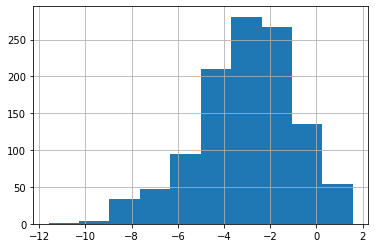

In [21]:
df['measured log solubility in mols per litre'].hist()

Note that RDKit includes a series of useful tools for working with Pandas, which are [documented here](http://rdkit.org/docs/source/rdkit.Chem.PandasTools.html). For instance, we can include the relevant molecule in each row of the dataframe:

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,Molecule
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,

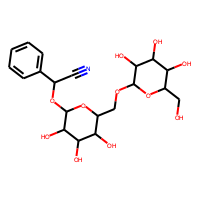
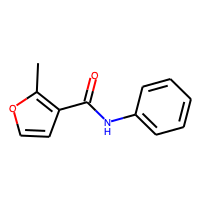
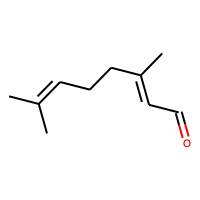
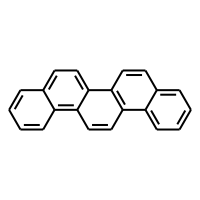
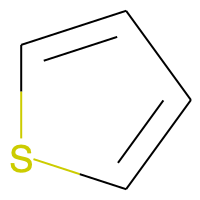

In [22]:
PandasTools.AddMoleculeColumnToFrame(df,'smiles','Molecule',includeFingerprints=False)
df.head()

Before moving on, we'll split this dataframe into train and validation dataframes:

In [23]:
def split_into_train_and_val_dfs(df: pd.DataFrame, train_proportion:float,
                                 rng: typing.Optional[np.random.RandomState]=None
                                ) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """
    splits this dataset into two: a training portion and a validation
    portion. 

    :param df: Pandas Dataframe to split up.
    :param train_proportion: proportion to use as training dataset
    """
    # If not passed in a random number generator create one here
    rng = np.random.RandomState(42) if rng is None else rng

    # Convert the proportion into a dataset size
    assert 0. <= train_proportion <= 1.
    number_for_training = int(np.ceil(train_proportion * df.shape[0]))

    # Create a random shuffling of the data
    perm = rng.permutation(df.shape[0])
    
    # split up into the appropriate sizes
    train_df = df.iloc[perm[:number_for_training]].copy()
    val_df = df.iloc[perm[number_for_training:]].copy()

    return train_df, val_df

train_df, val_df = split_into_train_and_val_dfs(df, 0.9)
print("Shapes are: ", train_df.shape, val_df.shape)

Shapes are:  (1016, 11) (112, 11)


### 3.2 Training a NN on fingerprints

Having set up our dataset we are now ready to create our first model! We first will train a regular feed forward NN on the fingerprints. I have written in the `ss_utils` module the training code for you, as the function `train_neural_network`. I highly encourage you to read over this function to see what is happening. As well as the data to train/validate on, this function requires the network to train as well as a function that converts SMILES strings into the required tensor to put into the network.


🧪   **Task 4:** Code up a 2-layer Pytorch NN that operates on 1024 dimensional fingerprint features and predicts the solubility. If you haven't used PyTorch before then you may find the [following documentation helpful](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). This neural network should be a subclass of `nn.Module`. You can pick whatever hidden dimensionality/hidden activation function you like.

<img src="https://raw.githubusercontent.com/john-bradshaw/ml-in-bioinformatics-summer-school-2020/master/imgs/nn_fingerprint.svg" width="800px" />





In [24]:
# Write a simple (1-hidden layer NN) in PyTorch
ff_nn: nn.Module = nn.Sequential(nn.Linear(1024, 128), nn.ReLU(), nn.Linear(128, 1))


# We also will need to add a transform for our datasets such that
# the network gets fed in fingerprint tensors rather than SMILES strings
def transform_ff_nn(smiles: str) -> torch.Tensor:
    fp = morgan_fp_from_smiles(smiles)
    tensor_fp = torch.tensor(fp, dtype=torch.float32)
    return tensor_fp


Having defined the network we can now train it:

In [25]:
# A quick check that the ff_nn has been subclassed from nn.Module correctly
assert isinstance(ff_nn, nn.Module), "The function you have written should be a subclass of nn.Module"

# Then we train and evaluate
out = ss_utils.train_neural_network(train_df, val_df, "smiles",
                                    "measured log solubility in mols per litre", transform_ff_nn, ff_nn)

# Finally we print out as a table some of the results.
display(HTML(tabulate.tabulate(out['out_table'], tablefmt="html")))

Train dataset is of size 1016 and valid of size 112
Epoch - 0
Training Results - Epoch: 0  Avg loss: 13.18
Validation Results - Epoch: 0 Avg loss: 11.13



Epoch - 1
Training Results - Epoch: 1  Avg loss: 6.36
Validation Results - Epoch: 1 Avg loss: 5.75



Epoch - 2
Training Results - Epoch: 2  Avg loss: 3.80
Validation Results - Epoch: 2 Avg loss: 4.03



Epoch - 3
Training Results - Epoch: 3  Avg loss: 2.77
Validation Results - Epoch: 3 Avg loss: 3.17



Epoch - 4
Training Results - Epoch: 4  Avg loss: 2.12
Validation Results - Epoch: 4 Avg loss: 2.62



Epoch - 5
Training Results - Epoch: 5  Avg loss: 1.67
Validation Results - Epoch: 5 Avg loss: 2.34



Epoch - 6
Training Results - Epoch: 6  Avg loss: 1.41
Validation Results - Epoch: 6 Avg loss: 2.12



Epoch - 7
Training Results - Epoch: 7  Avg loss: 1.24
Validation Results - Epoch: 7 Avg loss: 2.04



Epoch - 8
Training Results - Epoch: 8  Avg loss: 1.11
Validation Results - Epoch: 8 Avg loss: 1.99



Epoch - 9
Training Results - Epoch: 9  Avg loss: 1.01
Validation Results - Epoch: 9 Avg loss: 1.98



Epoch - 10
Training Results - Epoch: 10  Avg loss: 0.92
Validation Results - Epoch: 10 Avg loss: 1.96


Num params,131000
Minimum train loss,0.923
Mean validation time,0.571
Minimum validation loss,1.963


We can  plot these training and validation losses to better understand how training went (if the network has not converged feel free to run training for longer):

alt.LayerChart(...)

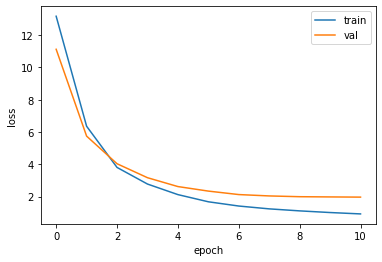

In [26]:
# We'll plot using Matplotlib and Altair.
# Altair is interactive which is nice, although I think matplotlib makes better static images when saving
# this notebook to GitHub.
ss_utils.plot_train_and_val_using_mpl(out['train_loss_list'], out['val_lost_list'])

ss_utils.plot_train_and_val_using_altair(out['train_loss_list'], out['val_lost_list'])


We can also add our predictions to the dataframe such that we can compare them more easily with the ground truth:

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,Molecule,NN FP predictions
690,"3,3-Dimethyl-1-butanol",-1.365,1,102.177,1,0,1,20.23,-0.50,CC(C)(C)CCO,,-1.796161
460,1-Pentanol,-1.042,1,88.150,1,0,3,20.23,-0.60,CCCCCO,,-3.335987
891,Diphenylmethane,-4.090,2,168.239,0,2,2,0.00,-4.08,C(c1ccccc1)c2ccccc2,,-2.606821
553,1-Iodobutane,-2.841,1,184.020,0,0,2,0.00,-2.96,CCCCI,,-3.201771
857,thioanisole,-2.870,1,124.208,0,1,1,0.00,-2.39,c1ccccc1SC,,-2.809479

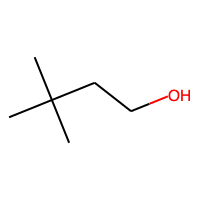
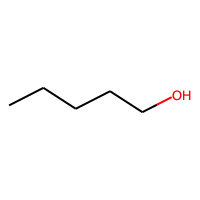
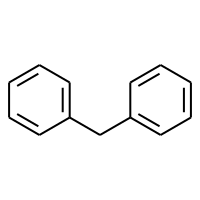
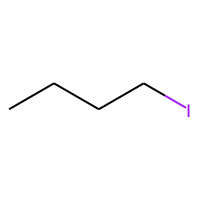
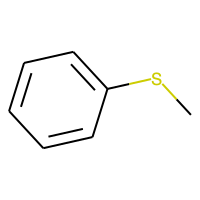

In [27]:
val_df['NN FP predictions'] = out['val_predictions']

val_df.head()

🕰  **(optional) Task C -- Different Feedforward NNs/Fingeprint Sizes:** Here we used 1024 dimensional features and a simple 2 layer NN. Explore using different dimensional fingerprints and different network architectures. As you use smaller fingerprints one bit may correspond to more substructures.
How about trying also some [other regression models](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) or [other descriptors](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html)?

### 3.3 Sequence based methods on SMILES string

As discussed in Miguel's lecture an alternative to fingerprints is to run a sequence based model directly on the SMILES strings. Two ways to do this are using RNNs and CNNs, which we are going to code up in this subsection. These models both break up the sequence into a series of symbols:

<img src="https://github.com/john-bradshaw/ml-in-bioinformatics-summer-school-2020/raw/master/imgs/RNNs_CNNs_on_smiles.png" width="600px"/>

(taken from [Miguel's slides](http://mlss.ii.uam.es/mlss2018/speakers.html))

We can then in turn represent each of these symbols in tensor form by using one-hot encodings. We'll therefore start by writing the transform to do this before writing the CNN and RNN models.

🧪   **Task 5:** Write the code to take in a SMILES string and convert it to a tensor where each row is each symbol's one-hot encoding. So for instance acetaldehyde, CC=O, should be represented as:  

\begin{bmatrix}
[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]\\
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]\\
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]\\
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]\\
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]\\
        \ldots
\end{bmatrix}
  
Padding will be needed at the end so that all sequences have the same length (you may find the [PyTorch function](https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.pad) `F.pad` useful in this regard). You should use the `SymbolFeaturizer` class from earlier to compute the one-hot encodings.
This code will be used to transform the data for the RNN/CNN models in a similar way the function `transform_ff_nn` did for the feedforward NN model above. 

In [28]:
# This will calculate the maximum SMILES string size in our data, which is the 
# same as the length we should ensure all tensors are padded to so that they can
# be batched:
max_seq_size = df['smiles'].map(len).max()

# This will calculate all the possible symbols in the smiles string:
symbols_in_smiles = set(itertools.chain(*df['smiles'].tolist()))
symbols_in_smiles = sorted(list(symbols_in_smiles))

# ...which we can then use to create a symbol featurizer
symbol_featurizer = SymbolFeaturizer(symbols_in_smiles)

In [29]:

class TransformSeqModel:
    def __init__(self, symbol_featurizer, max_seq_size):
        self.symbol_featurizer = symbol_featurizer
        self.max_seq_size = max_seq_size
    
    def __call__(self, smiles: str) -> torch.Tensor:
        """
        Transforms SMILES strings into one-hot encodings of each symbol present.
        
        :returns: a tensor (dtype=torch.float32) of size 
        [max_seq_size, one_hot_encoding_size]
        """
        one_hot_encodings = [self.symbol_featurizer(e) for e in smiles]
        one_hot_encodings = torch.tensor(one_hot_encodings, dtype=torch.float32)
        one_hot_encodings = F.pad(one_hot_encodings, (0,0,0, self.max_seq_size - one_hot_encodings.shape[0]))
        return one_hot_encodings
        
        
transform_seq_model = TransformSeqModel(symbol_featurizer, max_seq_size)

# You can check the function is correct by eyeballing the output for acetaldehyde
# (alternatively you could write a function that converts back to SMILES to check for you)
torch.set_printoptions(profile="full")
torch.nonzero(transform_seq_model("CC=O"))

/Users/john/anaconda3/envs/ss_moscow_2020/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/python_arg_parser.cpp:766.)


tensor([[ 0, 15],
        [ 1, 15],
        [ 2, 13],
        [ 3, 20]])

Having coded up a suitable transform we are left with creating the model! Let's start first with the RNN and then move onto the CNN.

🧪   **Task 6:** Complete the code below for a RNN to run on this sequence of one-hot encodings. For instance, you could use either a [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html?highlight=gru#torch.nn.GRU) or [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM). To form final predictions, project down the final hidden layer of the RNN to a one dimensional space using a linear layer. Be careful, the RNN will recieve the sequences _batch first_.


In [30]:

class RNNModel(nn.Module):
    def __init__(self, symbol_vocab_size: int):
        """
        :param symbol_vocab_size: the dimension of the one-hot vectors, ie how many symbols we have
        in total (and also the initial channel size being fed into the RNN.)
        """
        super().__init__()
        h_size = 128
        self.rnn = nn.GRU(input_size=symbol_vocab_size, hidden_size=h_size, num_layers=2,
                          batch_first=True, bias=True)
        # ^ nb you could use a bidirectional one if you wanted, more layers etc...
        self.lin = nn.Linear(h_size, 1)
        
    def forward(self, x):
        """
        :param x: tensor [batch_size, seq_size, symbol_vocab_size]
        :returns: tensor [batch_size, 1]
        """
        _, out = self.rnn(x)  # out = [num_layers, batch_size, hidden_size]
        out = out[-1]  # [batch_size, hidden_size]
        out = self.lin(out)  # [batch_size, 1]
        return out

rnn_model = RNNModel(len(symbols_in_smiles))

In [31]:
# We can check this model works by running it forward on two acetaldehydes batched up:
# (this should produce a two element column vector)
rnn_model(torch.stack([transform_seq_model("CC=O"), transform_seq_model("CC=O")]))


tensor([[-0.0405],
        [-0.0405]], grad_fn=<AddmmBackward>)

This done, we can train and evaluate our new model:

In [32]:
# Train and evaluate
out = ss_utils.train_neural_network(train_df, val_df, "smiles", "measured log solubility in mols per litre",
                                    transform_seq_model, rnn_model)

# And then we print out as a table some of the results.
display(HTML(tabulate.tabulate(out['out_table'], tablefmt="html")))

Train dataset is of size 1016 and valid of size 112
Epoch - 0
Training Results - Epoch: 0  Avg loss: 13.66
Validation Results - Epoch: 0 Avg loss: 11.52



Epoch - 1
Training Results - Epoch: 1  Avg loss: 5.36
Validation Results - Epoch: 1 Avg loss: 6.86



Epoch - 2
Training Results - Epoch: 2  Avg loss: 4.33
Validation Results - Epoch: 2 Avg loss: 4.90



Epoch - 3
Training Results - Epoch: 3  Avg loss: 4.33
Validation Results - Epoch: 3 Avg loss: 4.91



Epoch - 4
Training Results - Epoch: 4  Avg loss: 4.32
Validation Results - Epoch: 4 Avg loss: 4.96



Epoch - 5
Training Results - Epoch: 5  Avg loss: 4.32
Validation Results - Epoch: 5 Avg loss: 4.75



Epoch - 6
Training Results - Epoch: 6  Avg loss: 4.19
Validation Results - Epoch: 6 Avg loss: 4.90



Epoch - 7
Training Results - Epoch: 7  Avg loss: 3.75
Validation Results - Epoch: 7 Avg loss: 4.45



Epoch - 8
Training Results - Epoch: 8  Avg loss: 2.83
Validation Results - Epoch: 8 Avg loss: 3.75



Epoch - 9
Training Results - Epoch: 9  Avg loss: 1.64
Validation Results - Epoch: 9 Avg loss: 2.14



Epoch - 10
Training Results - Epoch: 10  Avg loss: 1.43
Validation Results - Epoch: 10 Avg loss: 1.88


Num params,161000
Minimum train loss,1.43
Mean validation time,0.248
Minimum validation loss,1.884


We can again plot the train/validation loss curves and check for too little training time or any overfitting:

alt.LayerChart(...)

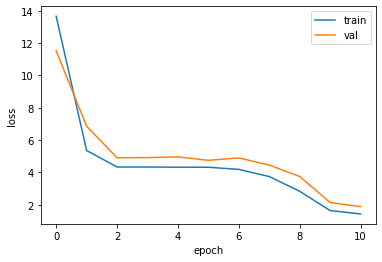

In [33]:
ss_utils.plot_train_and_val_using_mpl(out['train_loss_list'], out['val_lost_list'])

ss_utils.plot_train_and_val_using_altair(out['train_loss_list'], out['val_lost_list'])

This model can actually be harder to tune and choose sensible hyperparameters for than the simple feed forward neural network that we considered before. It is therefore useful to get a good baseline for performance, for instance by looking at the loss obtained by predicting the mean of the training set everwhere:

In [34]:
# Your model's loss should hopefully be lower than this dummy baseline's loss:
np.mean((val_df['measured log solubility in mols per litre'].values -
         train_df['measured log solubility in mols per litre'].mean())**2)

4.929260668175474

Did your model do better? If not, you probably want to go back and tune the RNN hyperparameters until it does. How do the different hyperparameters of the model affect performance?

When you've finished exploring that, let's move on to creating the convolutional neural network (CNN). This network, shown on the bottom of Miguel's slide above, will operate on the same input as the RNN, so we can reuse the same transform code (i.e. `TransformSeqModel`) and only need to write the new model code.

🧪   **Task 7:** Code up the CNN. PyTorch has `nn.Conv1d`, `nn.Conv2d` and `nn.Conv3d` layers, read the [documentation](https://pytorch.org/docs/stable/nn.html#convolution-layers) and work out which one is appropriate here. Your model should consist of one of these convolutional layers followed by a pooling layer and then a linear projection. 


In [35]:
class CNNModel(nn.Module):
    def __init__(self, symbol_vocab_size: int, seq_len:int):
        """
        :param symbol_vocab_size: the size of the one hot vectors (also the initial channel size for the CNN)
        :param seq_len: the size of all sequences.
        """
        super().__init__()
        
        # conv params
        self.channel_size_after_conv = 128
        kernel_size = 3
        
        # convolution:
        self.cnn = nn.Conv1d(in_channels=symbol_vocab_size,
                             out_channels=self.channel_size_after_conv,
                             kernel_size=kernel_size)
        out_size_after_conv = seq_len - kernel_size + 1
        # ^ computed using the formula on https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        # note this will change if you use padding, dilation, etc...
        
        # we will pool across all of sequence:
        self.pool = nn.AvgPool1d(kernel_size=out_size_after_conv)
        
        self.lin = nn.Linear(self.channel_size_after_conv, 1)
        
    def forward(self, x):
        """
        :param x: tensor [batch_size, seq_size, symbol_vocab_size (channel dim)]
        :returns: tensor [batch_size, 1]
        """
        batch_size, *_ = x.shape
        x = x.permute(0, 2, 1)  # [batch_size, symbol_vocab_size, seq_size]
        out = self.cnn(x)  # [batch_size, C_out, L_out]
        out = self.pool(out)  # [batch_size, C_out, 1]
        out = out.view(batch_size, self.channel_size_after_conv) #  [batch_size, C_out]
        out = self.lin(out)
        return out

    
cnn_model = CNNModel(len(symbols_in_smiles), max_seq_size)

In [36]:
# we can again quickly check that it works before its trained by running it once forward.
cnn_model(torch.stack([transform_seq_model("CC=O"), transform_seq_model("CC=O")]))

tensor([[0.1113],
        [0.1113]], grad_fn=<AddmmBackward>)

Having created the model we can now train it, the same way we have done for the RNN:

In [37]:
# Then we train and evaluate
out = ss_utils.train_neural_network(train_df, val_df, "smiles", 
                                    "measured log solubility in mols per litre", transform_seq_model, cnn_model)

# And then we print out as a table some of the results.
display(HTML(tabulate.tabulate(out['out_table'], tablefmt="html")))

Train dataset is of size 1016 and valid of size 112
Epoch - 0
Training Results - Epoch: 0  Avg loss: 14.60
Validation Results - Epoch: 0 Avg loss: 12.33



Epoch - 1
Training Results - Epoch: 1  Avg loss: 12.83
Validation Results - Epoch: 1 Avg loss: 10.86



Epoch - 2
Training Results - Epoch: 2  Avg loss: 10.99
Validation Results - Epoch: 2 Avg loss: 9.37



Epoch - 3
Training Results - Epoch: 3  Avg loss: 8.85
Validation Results - Epoch: 3 Avg loss: 7.68



Epoch - 4
Training Results - Epoch: 4  Avg loss: 6.63
Validation Results - Epoch: 4 Avg loss: 5.99



Epoch - 5
Training Results - Epoch: 5  Avg loss: 4.67
Validation Results - Epoch: 5 Avg loss: 4.61



Epoch - 6
Training Results - Epoch: 6  Avg loss: 3.54
Validation Results - Epoch: 6 Avg loss: 3.95



Epoch - 7
Training Results - Epoch: 7  Avg loss: 3.12
Validation Results - Epoch: 7 Avg loss: 3.84



Epoch - 8
Training Results - Epoch: 8  Avg loss: 3.01
Validation Results - Epoch: 8 Avg loss: 3.87



Epoch - 9
Training Results - Epoch: 9  Avg loss: 2.93
Validation Results - Epoch: 9 Avg loss: 3.81



Epoch - 10
Training Results - Epoch: 10  Avg loss: 2.85
Validation Results - Epoch: 10 Avg loss: 3.74


Num params,12500
Minimum train loss,2.854
Mean validation time,0.091
Minimum validation loss,3.741


alt.LayerChart(...)

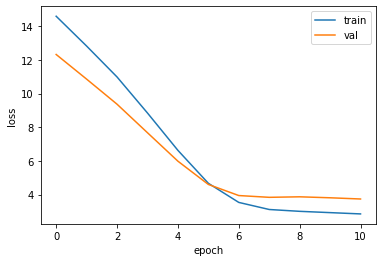

In [38]:
# and we can plot the loss curves:

ss_utils.plot_train_and_val_using_mpl(out['train_loss_list'], out['val_lost_list'])

ss_utils.plot_train_and_val_using_altair(out['train_loss_list'], out['val_lost_list'])


What pooling operation works best? How does performance in terms of loss, number of parameters and timings compare to the RNN? Does adding additional convolutional layers change this?


🕰  **(optional) Task C -- Augmented Sequences:** Earlier in this notebook we discussed how each molecule corresponds to many SMILES strings. However, in this section we have only fed into the networks one of the possible SMILES strings for each molecule. Consider training the sequence models in this section on an augmented dataset (i.e. create a transform that randomly chooses a different SMILES representation each time it is called), and see how this affects the final models performance. You can also implement a method to pool predictions made using the different SMILES representations at inference time. Bjerrum (2017) explores this idea. Do you obtain similar results? 

🕰  **(optional) Task D -- Symbol Embeddings:**  We fed in as features to the RNN/CNNs one hot encodings of each symbol. Consider using [learnt embeddings instead](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) (the `nn.Embedding` class may be useful here). How does this affect performance? How many extra parameters does this result in? How does this modification compare to just adding an additional layer to your network and why?  
Furthermore, as an additional related extension, can you group together some of the current symbols to reduce sequence sizes and the number of embeddings needed (i.e. currently we represent bromine as 'B' 'r' can you instead ensure it is kept as one symbol 'Br')? You may find the following regex (taken from Schwaller et al. (2019)) useful:  
`"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"`



### 3.4 Graph Neural Networks

The final model we will consider here is a basic graph neural network. 

As you saw in Section 2 of this notebook, graphs require several tensors to represent them. Therefore, we will begin by creating a datastructure to keep these tensors together as well as to allow the easy batching of several graphs together (so that we can train our network using minibatches). We will then go on to creating the network itself before trying it out on the same small solubility dataset that the other methods have been running on.


🧪   **Task 8:** Complete the `Graph` class below. To be more specific, you need to fill in the class method, `concatenate`, that given a list of individual graphs returns a new instance of the class with them all batched together. 



In [39]:
class Graphs:
    ATOM_FEATURIZER = SymbolFeaturizer(['Ag', 'Al', 'Ar', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C',
                    'Ca', 'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Eu', 'F',
                    'Fe', 'Ga', 'Ge', 'H', 'He', 'Hf', 'Hg', 'I', 'In', 'Ir', 'K', 'La',
                    'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nd', 'Ni', 'O', 'Os', 'P', 'Pb',
                    'Pd', 'Pr', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se',
                    'Si', 'Sm', 'Sn', 'Sr', 'Ta', 'Te', 'Ti', 'Tl', 'V', 'W', 'Xe', 'Y',
                    'Yb', 'Zn', 'Zr'])
    # ^ you can change the number of symbols here to play with the dimensionality,
    # we only need to have the symbols: ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']

    BOND_FEATURIZER = SymbolFeaturizer([1., 1.5, 2., 3.])  
    # ^ single, aromatic, double and triple bonds (see earlier how RDKit represents these as doubles.)
    
    def __init__(self, node_features: torch.Tensor, 
                 edge_list: torch.Tensor, edge_features: torch.Tensor, node_to_graph_id: torch.Tensor):
        """
        A graph datastructure which groups together the series of tensors that represent the
        graph. Note that this datastructure also holds multiple molecule graphs as one large 
        disconnected graph -- the nodes belonging to each molecule are described by node_to_graph_id.
        
        ## Further details on the individual tensors
        Say this graph represents acetone, CC(=O)C, and ethane, CC, and we're using a simple 
        three dimensional one-hot encoding for 'C', 'O' and 'N' and a simple two dimensional
        one-hot encoding for the bonds 'SINGLE', 'DOUBLE' then the resulting tensors would look
        like:
        node_features = [[1. 0. 0.], 
                         [1. 0. 0.], 
                         [0. 1. 0.], 
                         [1. 0. 0.],
                         [1. 0. 0.],
                         [1. 0. 0.]]
        edge_list = [[0 1],
                     [1 0],
                     [1 2],
                     [2 1],
                     [1 3],
                     [3 1],
                     [4 5],
                     [5 4]]
                     
        edge_features = [[1. 0.],
                         [1. 0.],
                         [0. 1.],
                         [0. 1.],
                         [1. 0.],
                         [1. 0.],
                         [1. 0.],
                         [1. 0.]]
                         
        node_to_graph_id = [0 0 0 0 1 1]
        
                         
        More generally we expect the different tensors to have the following datatypes and shapes
        (below N is number of nodes, E number of edges, h_n the feature dimensionality of node
        features and h_e the feature dimensionality of edge features):
        
        :param node_features: Tensor (dtype float32 , shape [N, h_n])
        :param edge_list: Tensor (dtype int64 , shape [E, 2])
        :param edge_features: Tensor (dtype float32 , shape [E, h_e])
        :param node_to_graph_id: Tensor (dtype int64 , shape [N]) this contains for each node
           the associated graph it belongs to. So for instance if this Graph datastructure 
           represented only one graph this should be all zeros, however if two then it should be
           zeros for the nodes corresponding to the first graph and then 1s for the second graph.
           Graph ids should start at one and consist of consectutive integers.
        """
        self.node_features = node_features
        self.edge_list = edge_list
        self.edge_features = edge_features
        self.node_to_graph_id = node_to_graph_id
        
    def to(self, *args, **kwargs):
        """
        Works in a similar way to the Tensor function torch.Tensor.to(...)
        and performs  dtype and/or device conversion for the entire datastructure
        """
        new_graph = type(self)(self.node_features.to(*args, **kwargs),
                               self.edge_list.to(*args, **kwargs),
                               self.edge_features.to(*args, **kwargs),
                               self.node_to_graph_id.to(*args, **kwargs)
                              )
        return new_graph
    
    @classmethod
    def from_smiles_string(cls, smiles_str: str):
        """
        Converts a SMILES string into the representation required by this datastructure.
        Making use of the code you wrote in Section 2!
        """
        # Convert to form we need using previous code:
        mol = Chem.MolFromSmiles(smiles_str)
        node_features, edge_list, edge_features = mol_to_edge_list_graph(mol, cls.ATOM_FEATURIZER)
        edge_features = [cls.BOND_FEATURIZER(elem) for elem in edge_features]
        # ^ nb here we're converting the edge feature list into one-hot form
        
        # Convert to tensors:
        node_features = torch.tensor(node_features, dtype=torch.float32)
        edge_list = torch.tensor(edge_list, dtype=torch.int64)
        edge_features = torch.tensor(edge_features, dtype=torch.float32)
        node_to_graph_id = torch.zeros(node_features.shape[0], dtype=torch.int64)
        # ^we only (currently) have one molecule per SMILES so all the nodes can be assigned 
        # the same id
        
        return cls(node_features, edge_list, edge_features, node_to_graph_id)
    
    @property
    def num_graphs(self):
        return torch.unique(self.node_to_graph_id).shape[0]
    
    @classmethod
    def concatenate(cls, list_of_graphs):
        """
        This takes in a list of objects of this class and joins them to form one large disconnected graph.
        
        For instance say we have two individual `Graphs` instances, one for acetone (CC(=O)C) and one for 
        ethane (CC) they might look like this (in pseudocode -- note also in practice are one-hot encoding
        is larger):
        acetone = Graphs(
            node_features = [[1. 0. 0.], 
                             [1. 0. 0.], 
                             [0. 1. 0.], 
                             [1. 0. 0.]]
            edge_list = [[0 1],
                         [1 0],
                         [1 2],
                         [2 1],
                         [1 3],
                         [3 1]]
            edge_features = [[1. 0.],
                             [1. 0.],
                             [0. 1.],
                             [0. 1.],
                             [1. 0.],
                             [1. 0.]]
            node_to_graph_id = [0 0 0 0]            
        )
        
        ethane = Graphs(
            node_features = [[1. 0. 0.], 
                             [1. 0. 0.]]
            edge_list = [[0 1],
                         [1 0]]
            edge_features = [[1. 0.],
                             [1. 0.]]
            node_to_graph_id = [0 0]            
        )
        
        and this function would transform them into one large disconnected graph
        minibatch_of_graphs = Graphs(
                node_features = [[1. 0. 0.], 
                                 [1. 0. 0.], 
                                 [0. 1. 0.], 
                                 [1. 0. 0.],
                                 [1. 0. 0.],
                                 [1. 0. 0.]]
                edge_list = [[0 1],
                             [1 0],
                             [1 2],
                             [2 1],
                             [1 3],
                             [3 1],
                             [4 5],
                             [5 4]]
                edge_features = [[1. 0.],
                                 [1. 0.],
                                 [0. 1.],
                                 [0. 1.],
                                 [1. 0.],
                                 [1. 0.],
                                 [1. 0.],
                                 [1. 0.]]
                node_to_graph_id = [0 0 0 0 1 1]
                )
        """
        # node features and edge_features simply get concatenated
        new_node_features = torch.cat([e.node_features for e in list_of_graphs], dim=0)
        new_edge_features = torch.cat([e.edge_features for e in list_of_graphs], dim=0)
        
        # edge_list and node
        new_edge_lists = []
        new_node_ids = []
        num_nodes_seen_so_far = 0
        num_graphs_so_far = 0
        for graph in list_of_graphs:
            new_edge_lists.append(graph.edge_list + num_nodes_seen_so_far)
            # ^ shift up the edges to reflect the nodes new indices
            
            new_node_ids.append(graph.node_to_graph_id + num_graphs_so_far)
            # ^shift up the node to graph id to reflect the number of graphs before
            
            num_nodes_seen_so_far += graph.node_features.shape[0]
            num_graphs_so_far +=  torch.unique(graph.node_to_graph_id).shape[0]
        
        new_edge_lists = torch.cat(new_edge_lists, dim=0)
        new_new_node_ids = torch.cat(new_node_ids, dim=0)
        
        new_concatenated_graph = cls(node_features=new_node_features,
                                     edge_list=new_edge_lists,
                                     edge_features=new_edge_features,
                                     node_to_graph_id=new_new_node_ids)
        return new_concatenated_graph
    
    
# We're now going to create an instance of this class and test the concatenate function
# (you could also write a reverse function if you wanted to be sure your code worked correctly)
acetone_g = Graphs.from_smiles_string('CC(=O)C')
ethane_g = Graphs.from_smiles_string('CC')        
    
graph_of_both = Graphs.concatenate([acetone_g, ethane_g])
print(f"graph_of_both.node_features:\n{graph_of_both.node_features}\n\n")
print(f"graph_of_both.edge_list:\n{graph_of_both.edge_list}\n\n")
print(f"graph_of_both.edge_features:\n{graph_of_both.edge_features}\n\n")
print(f"graph_of_both.node_to_graph_id:\n{graph_of_both.node_to_graph_id}\n\n")

graph_of_both.node_features:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Having created the `Graphs` datastructure we can now create our graph neural network (GNN) which gets fed in the `Graphs` class as input. At a high level, the GNN consists of a series of message passing steps, which update the node features. After computing richer node features in this manner, a graph-level representation is computed through a weighted sum of the node features, in a process described as an aggregation transformation (Johnson, 2017) (also often called a readout step (Gilmer et al.,2017)). Finally, this graph-level representation is projected down by a linear transform to predict the solubility property score.

We are going to base the specifics of our GNN implementation on Gated Graph Neural Networks (Li et al., 2015), with the update function performed using a GRU. We will ignore implementing a global state or distinguishing the messages based on edge type -- these will be left as possible extensions to you! To be more specific, the node representations $\mathbf{m}_v^t$ for node $v$ at propagation step $t$ will be updated by:  

\begin{array}
 \mathbf{m}_v^{t} = \textrm{GRU}(\sum_{j \in \mathcal{N}(v)} \mathbf{W} \mathbf{m}_j^{t-1}, \mathbf{m}_v^{t-1}), \tag{1}
\end{array} 

where $W$ is a learnt weight matrix, $\mathcal{N}(v)$ denotes the neighbour nodes of $v$, and $\textrm{GRU}$ refers to a Gated Recurrent Unit RNN (Cho et al., 2014). $\mathbf{m}_v^0$ will be set as the one-hot encodings of the atom type and we will proceed for $T$ iterations. Pictorially this process is shown below:

<img src="https://raw.githubusercontent.com/john-bradshaw/ml-in-bioinformatics-summer-school-2020/master/imgs/mpnn.svg" width="850px" />



We compute a graph level embedding, $\mathbf{g}$, for graph $\mathcal{G}$ through the aggregation function as follows (altogether this can be thought of as a learnable fingerprint function):  

\begin{array}
\mathbf{g} = \sum_{v \in \mathcal{G}} \sigma\left(f_\textrm{attn}(\mathbf{m}_v^T)\right) f_\textrm{proj}(\mathbf{m}_v^T), \tag{2}
\end{array}

where $\sigma(\cdot)$ is the sigmoid function, and $f_\textrm{attn}(\cdot)$ and $f_\textrm{proj}(\cdot)$ are two linear projections; the sum is over all of the nodes (i.e. atoms) in the graph. Pictorially this looks like:

<img src="https://raw.githubusercontent.com/john-bradshaw/ml-in-bioinformatics-summer-school-2020/master/imgs/mpnn_aggr.svg" width="850px" />


🧪   **Task 9:** Fill in the missing code in the GNN implmentation below. You can see the missing pieces from the comments.

In [40]:
class GNN(nn.Module):
    def __init__(self, node_feature_dimension, num_propagation_steps:int =4):
        super().__init__()
        
        self.num_propagation_steps = num_propagation_steps
        # called T above.
        
        # Our sub modules:
        self.message_projection = nn.Linear(node_feature_dimension, node_feature_dimension, bias=False)
        self.update_gru = nn.GRUCell(input_size=node_feature_dimension,
                                     hidden_size=node_feature_dimension, bias=True)
        self.attn_net = nn.Linear(node_feature_dimension, 1)
        self.proj_net = nn.Linear(node_feature_dimension, node_feature_dimension)
        self.final_lin = nn.Linear(node_feature_dimension, 1)
        
    def forward(self, graphs_in: Graphs):
        """
        Produces a column vector of predictions, with each element in this vector a prediction
        for each marked graph in `graphs_in`.
        
        In the comments below N is the number of nodes in graph_in (across all graphs), 
        d the feature dimension, and G is the number of individual molecular graphs.        
        """
        # 1. Message passing and updating
        m = graphs_in.node_features  # shape: [N, d]
        
        for t in range(self.num_propagation_steps):
            projs = self.message_projection(m)  # [N, d]
            
            # Update the node embeddings (eqn 1 above)
            # 1a. compute the sum for each node
            msgs = torch.zeros_like(m)  # [N, d]
            msgs.index_add_(0, graphs_in.edge_list[:, 0], projs.index_select(0, graphs_in.edge_list[:, 1]))
            
            # 1b. update the embeddings via GRU cell
            m = self.update_gru(msgs, m)  # [N, d]
            
            
        # 2. Aggregation (eqn 2 above)
        # a compute weighted embeddings
        attn_coeffs = torch.sigmoid(self.attn_net(m))  # [N, 1]
        proj_embeddings = self.proj_net(m)  # [N, d']
        weighted_embeddings = attn_coeffs * proj_embeddings
        
        # perform the sum
        graph_embedding = torch.zeros(graphs_in.num_graphs, weighted_embeddings.shape[1],
                                 device=m.device, dtype=m.dtype)  
        graph_embedding.index_add_(0, graphs_in.node_to_graph_id, weighted_embeddings)  # [G, d']
        
        # 3. Final linear projection.
        final_prediction = self.final_lin(graph_embedding)  # [G, 1]
        return final_prediction
    
    
gnn = GNN(len(Graphs.ATOM_FEATURIZER.indx2atm))

Before we can run our training loop with our new model we need to tell the PyTorch `Dataloader` (used in `ss_utils`) how to collate the graphs together when forming minibatches (the main machinery of how this happens you have already written in task 7 above). 

In [41]:
def collate_for_graphs(batch):
    """
    This is a custom collate function for use minibatches of graphs along with their regression value.
    It ensures that we concatenate graphs correctly.
    
    Look at ss_utils to see how this gets used.
    """
    # Split up the graphs and the y values
    list_of_graphs, list_of_targets = zip(*batch)
    list_of_graphs = list(list_of_graphs)
    list_of_targets = list(list_of_targets)
    
    # The graphs need to be concatenated (i.e. collated) using the function you wrote
    graphs = Graphs.concatenate(list_of_graphs)
    
    # The y values can use the default collate function as before.
    targets = data.dataloader.default_collate(list_of_targets)
    
    return graphs, targets

And now we can train!

In [42]:
# Then we train and evaluate
out = ss_utils.train_neural_network(train_df, val_df, "smiles", "measured log solubility in mols per litre",
                                    transform=Graphs.from_smiles_string, neural_network=gnn,
                                   collate_func=collate_for_graphs)

# And then we print out as a table some of the results.
display(HTML(tabulate.tabulate(out['out_table'], tablefmt="html")))

Train dataset is of size 1016 and valid of size 112
Epoch - 0
Training Results - Epoch: 0  Avg loss: 11.98
Validation Results - Epoch: 0 Avg loss: 10.20



Epoch - 1
Training Results - Epoch: 1  Avg loss: 3.43
Validation Results - Epoch: 1 Avg loss: 3.66



Epoch - 2
Training Results - Epoch: 2  Avg loss: 2.89
Validation Results - Epoch: 2 Avg loss: 3.34



Epoch - 3
Training Results - Epoch: 3  Avg loss: 2.46
Validation Results - Epoch: 3 Avg loss: 2.92



Epoch - 4
Training Results - Epoch: 4  Avg loss: 2.09
Validation Results - Epoch: 4 Avg loss: 2.10



Epoch - 5
Training Results - Epoch: 5  Avg loss: 1.41
Validation Results - Epoch: 5 Avg loss: 1.85



Epoch - 6
Training Results - Epoch: 6  Avg loss: 1.39
Validation Results - Epoch: 6 Avg loss: 1.78



Epoch - 7
Training Results - Epoch: 7  Avg loss: 1.28
Validation Results - Epoch: 7 Avg loss: 1.65



Epoch - 8
Training Results - Epoch: 8  Avg loss: 1.27
Validation Results - Epoch: 8 Avg loss: 1.75



Epoch - 9
Training Results - Epoch: 9  Avg loss: 1.18
Validation Results - Epoch: 9 Avg loss: 1.65



Epoch - 10
Training Results - Epoch: 10  Avg loss: 1.22
Validation Results - Epoch: 10 Avg loss: 1.70


Num params,42100
Minimum train loss,1.178
Mean validation time,0.17
Minimum validation loss,1.651


alt.LayerChart(...)

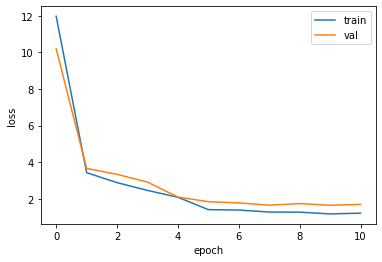

In [43]:
# and we can plot the loss curves:

ss_utils.plot_train_and_val_using_mpl(out['train_loss_list'], out['val_lost_list'])

ss_utils.plot_train_and_val_using_altair(out['train_loss_list'], out['val_lost_list'])


How did it perform? How did the the number of parameters compare to some of the alternative methods, is this what you expected?

🕰  **(optional) Task E -- GNN Modeling Choices:** There are quite a few design choices one can make when deciding on the architecture of a GNN (Gilmer, 2017; Brockschmidt, 2019). Play around with some of these choices. For instance:  
* Currently the edge feature information is ignored. Consider instead using this information to adapt the $W$ matrix based on the associated edge type.
* What is the effect of using different initial atom features? For example could you add the valency and  hydrogen count to the element one-hot encoding (Duvenaud et al., 2015 , §4.2)?
* Consider the addition of virtual edges between all nodes or a master virtual node such that messages can be passed more easily between nodes that are far apart (Gilmer et al., 2017, §5.2).
* Consider using attention (Veličković et al., 2017) in the sum when computing messages (Eqn. 1) to downweight/upweight the contribution of different neighbours.


🕰  **(optional) Task F -- Combining Representations:** We have now gone through several alternative methods to compute vector representations of molecules. However, these can also be combined, for instance you could concatenate fingerprints and the GNN output to form a graph level representation (Yang et al., 2019, p3373). Try doing this and exploring different ways to combine features from the different models. 




### Section 3.5 Summary and further reading

In this section we looked at how to code up different regression models for molecules. In particular, we looked at NNs on fingerprints, CNN and RNNs on SMILES strings, and GNNs on molecular graphs. We tried to get some inutition for their performance and compute characteristics and offered pointers to how the basic implementations of each could be extended. I should quickly point out that we have not performed any extensive hyperparameter/architecture search or evaluated the models on more complicated datasets, both of which would be required in a more comprehensive comparison. If you wish to do this you could follow up on some of the extension tasks and consider some of the architectures/datasets used in the references provided!

GNNs (and related models) have quite a long history in chemoinformatics, e.g. (Kireev, 1995; Merkwirth and Lengauer, 2005). They have also picked up a lot of interest recently in the ML community, where they have also been used to represent many other kinds of data such as physical systems, citation networks, knowledge graphs, or social networks (e.g. see (Kipf and Welling, 2017; Battaglia et al., 2016; Hu et al., 2020; Dai et al., 2017; Hamilton et al., 2017; Bronstein et al., 2016) and the references therein).  Battaglia et al.  (2018), especially §3-4, is well worth reading, as it unifies some of the existing approaches as does Gilmer et al. (2017).

In this notebook we presented one pattern for implementing graph neural networks based on maintaing an edge list. This enabled the easy batching together of multiple graphs with different numbers of nodes (through the `concatenate` function you wrote). However, alternative patterns also have their own pros/cons, for instance you can store graphs as adjacency matrices and do the message passing step by matrix multiplication; you can find my code for playing around with such ideas [here](https://github.com/john-bradshaw/GNN). If you want well-documented, well-maintained libraries for working with GNNs, I recommend checking out [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) or the [Deep Graph Library (DGL)](https://github.com/dmlc/dgl). You can see recent talks talking about what is new in these libraries at this [recent ICML workshop (time 3:42:42)](https://icml.cc/virtual/2020/workshop/5715).

## References

Weininger D (1988) SMILES, a chemical language and information system. 1. Introduction to methodology and encoding rules. Journal of chemical information and computer sciences 28(1). American Chemical Society: 31–36.

Heller, S., McNaught, A., Stein, S., Tchekhovskoi, D. and Pletnev, I. (2013) ‘InChI - the worldwide chemical structure identifier standard’, Journal of cheminformatics, 5(1), p. 7.

Shervashidze, N., Schweitzer, P., Van Leeuwen, E. J., Mehlhorn, K. and Borgwardt, K. M. (2011) ‘Weisfeiler-Lehman graph kernels’, Journal of machine learning research: JMLR, 12(9). Available at: https://jmlr.csail.mit.edu/papers/volume12/shervashidze11a/shervashidze11a.pdf.

Duvenaud, D., Maclaurin, D., Aguilera-Iparraguirre, J., Gómez-Bombarelli, R., Hirzel, T., Aspuru-Guzik, A. and Adams, R. P. (2015) ‘Convolutional Networks on Graphs for Learning Molecular Fingerprints’, arXiv [cs.LG]. Available at: http://arxiv.org/abs/1509.09292.

Rogers, D. and Hahn, M. (2010) ‘Extended-connectivity fingerprints’, Journal of chemical information and modeling, 50(5), pp. 742–754.

Gilmer, J., Schoenholz, S. S., Riley, P. F., Vinyals, O. and Dahl, G. E. (2017) ‘Neural Message Passing for Quantum Chemistry’, arXiv [cs.LG]. Available at: http://arxiv.org/abs/1704.01212.

Riniker, S. and Landrum, G. A. (2013) ‘Open-source platform to benchmark fingerprints for ligand-based virtual screening’, Journal of cheminformatics, 5(1), p. 26.

Bjerrum, E. J. (2017) ‘SMILES Enumeration as Data Augmentation for Neural Network Modeling of Molecules’, arXiv [cs.LG]. Available at: http://arxiv.org/abs/1703.07076.

Schwaller, P., Laino, T., Gaudin, T., Bolgar, P., Hunter, C. A., Bekas, C. and Lee, A. A. (2019) ‘Molecular Transformer: A Model for Uncertainty-Calibrated Chemical Reaction Prediction’, ACS central science, 5(9), pp. 1572–1583.

Johnson, D. D. (2017) ‘Learning Graphical State Transitions’, in ICLR. Available at: https://openreview.net/pdf?id=HJ0NvFzxl (Accessed: 2 August 2018).

Li, Y., Tarlow, D., Brockschmidt, M. and Zemel, R. (2015) ‘Gated Graph Sequence Neural Networks’, arXiv [cs.LG]. Available at: http://arxiv.org/abs/1511.05493.

Cho, K., van Merrienboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H. and Bengio, Y. (2014) ‘Learning Phrase Representations using RNN Encoder--Decoder for Statistical Machine Translation’, in Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), pp. 1724–1734.

Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P. and Bengio, Y. (2017) ‘Graph Attention Networks’, arXiv [stat.ML]. Available at: http://arxiv.org/abs/1710.10903.

Brockschmidt, M. (2019) ‘GNN-FiLM: Graph Neural Networks with Feature-wise Linear Modulation’, arXiv [cs.LG]. Available at: http://arxiv.org/abs/1906.12192.

Yang, K., Swanson, K., Jin, W., Coley, C., Eiden, P., Gao, H., Guzman-Perez, A., Hopper, T., Kelley, B., Mathea, M., Palmer, A., Settels, V., Jaakkola, T., Jensen, K. and Barzilay, R. (2019) ‘Analyzing Learned Molecular Representations for Property Prediction’, Journal of chemical information and modeling, 59(8), pp. 3370–3388.

Kireev, D. B. (1995) ‘ChemNet: A Novel Neural Network Based Method for Graph/Property Mapping’, Journal of chemical information and computer sciences. American Chemical Society, 35(2), pp. 175–180.

Merkwirth, C. and Lengauer, T. (2005) ‘Automatic generation of complementary descriptors with molecular graph networks’, Journal of chemical information and modeling, 45(5), pp. 1159–1168.

Kipf, T. N. and Welling, M. (2017) ‘Semi-Supervised Classification with Graph Convolutional Networks’, in. ICLR. Available at: http://arxiv.org/abs/1609.02907.

Hamilton, W. L., Ying, R. and Leskovec, J. (2017) ‘Representation Learning on Graphs: Methods and Applications’, arXiv [cs.SI]. Available at: http://arxiv.org/abs/1709.05584.

Battaglia, P. W., Hamrick, J. B., Bapst, V., Sanchez-Gonzalez, A., Zambaldi, V., Malinowski, M., Tacchetti, A., Raposo, D., Santoro, A., Faulkner, R., Gulcehre, C., Song, F., Ballard, A., Gilmer, J., Dahl, G., Vaswani, A., Allen, K., Nash, C., Langston, V., Dyer, C., Heess, N., Wierstra, D., Kohli, P., Botvinick, M., Vinyals, O., Li, Y. and Pascanu, R. (2018) ‘Relational inductive biases, deep learning, and graph networks’, arXiv [cs.LG]. Available at: http://arxiv.org/abs/1806.01261.

Battaglia, P. W., Pascanu, R., Lai, M., Rezende, D. and Kavukcuoglu, K. (2016) ‘Interaction Networks for Learning about Objects, Relations and Physics’, arXiv [cs.AI]. Available at: http://arxiv.org/abs/1612.00222.

Hu, W., Fey, M., Zitnik, M., Dong, Y., Ren, H., Liu, B., Catasta, M. and Leskovec, J. (2020) ‘Open Graph Benchmark: Datasets for Machine Learning on Graphs’, arXiv [cs.LG]. Available at: http://arxiv.org/abs/2005.00687.

Dai, H., Khalil, E. B., Zhang, Y., Dilkina, B. and Song, L. (2017) ‘Learning Combinatorial Optimization Algorithms over Graphs’, arXiv [cs.LG]. Available at: http://arxiv.org/abs/1704.01665.

William L. Hamilton. (2020). Graph Representation Learning. Morgan & Claypool, forthcoming .

Bronstein, M. M., Bruna, J., LeCun, Y., Szlam, A. and Vandergheynst, P. (2016) ‘Geometric deep learning: going beyond Euclidean data’, arXiv [cs.CV]. Available at: http://arxiv.org/abs/1611.08097.

Delaney, J. S. (2004) ‘ESOL: estimating aqueous solubility directly from molecular structure’, Journal of chemical information and computer sciences, 44(3), pp. 1000–1005.